<a href="https://colab.research.google.com/github/jsoldadomagraner/Comp_Neuro-ML_course/blob/main/projects/theory/RNN_working_memory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNN simulation


\begin{equation}
\tau_{m}\frac{dr}{dt} = -r + f(J r + J_{in} I) \\
f(x) = tanh(x)
\end{equation}

<br>
<br>
<br>

<div>
<center><img src="./RNN.png/" width=300></center>
</div>

<br>
<br>
<br>
This code has been adapted from the Neuromatch academy by ssaray@ucla.edu


In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
# Set some properties of the model. We'll store these in a dict so they're
# easier to pass around or save.
model = {}

# properties of the recurrent pool:
model['N'] = 1000  # number of neurons
model['g'] = 0.95  # gain of synaptic weights in pool
model['sp'] = 0.25  # fraction of weights that are nonzero
model['tau'] = 20  # neural membrane time constant in ms
model['dt'] = 0.1  # simulation timestep in ms
model['nonlin'] = lambda x: np.tanh(x)  # firing rate nonlinearity for pool units

# properties of the input layer:
# a note: we're going to encode the "value" of the input by the identity of the
# active input layer units. We'll use one-hot encoding: for each input step
# during simulation, one unit will be activated with "firing rate" 1, and the
# rest will be set to firing rate 0 (adjust gIn to change the scaling of input
# to the recurrent pool.)
# Note 1: This is just one way of setting up input- are there other approaches
# that would improve memory capacity?
# Note 2: Burn-in time is especially important if your model has g>1, in which
# case neurons will be spontaneously active.
model['nIn'] = 20  # size of the input layer
model['gIn'] = 10.0  # gain of the input weights
model['spIn'] = 0.05  # sparsity of input->pool connectivity
model['burnIn'] = 10  # time before input starts
model['durIn'] = 1  # time for which an input is active in ms
model['ISI'] = 0  # time between inputs in ms
model['nonlinIn'] = lambda x: x  # best to keep the input linear

In [3]:
# Create the synaptic weight matrix.
# Normalizing weights by sqrt(N*sparsity) keeps the eigenvalue spectrum
# invariant to the size of the population N.
randMat  = np.random.normal(0, 1, size=(model['N'], model['N']))
spMat  = np.random.uniform(0, 1, size=(model['N'], model['N'])) <= model['sp']
model['J'] = np.multiply(randMat, spMat) * model['g'] / math.sqrt(model['N'] * model['sp'])

# Create the input weight matrix.
randMatIn = np.random.normal(0, 1, size=(model['N'], model['nIn']))
spMatIn = np.random.uniform(0, 1, size=(model['N'], model['nIn'])) <= model['spIn']
model['Jin'] = np.multiply(randMatIn, spMatIn) * model['gIn'] / math.sqrt(model['nIn'] * model['spIn'])

In [4]:
# Define a couple helper functions for simulation.

def step(firing_rates, input_layer, model):
  # The simulation function. We use Euler's method to simulate the evolution of
  # model neuron firing rates given the input_layer firing rates.

  timestep = math.exp(-model['dt']/model['tau'])
  vIn = np.matmul(model['J'], firing_rates) \
        + np.matmul(model['Jin'], model['nonlinIn'](input_layer))
  updated_rates = model['nonlin'](vIn + (firing_rates - vIn) * timestep)

  return updated_rates


def make_input(sequence_length, model):
  # Generates a sequence of inputs according to the parameters in model. Returns
  # the sequence both as a one-hot encoding and as a sequence of integer values.

  input_stream = [0] * int(model['burnIn']/model['dt'])

  for i in range(sequence_length):
    val = np.random.randint(0, model['nIn']) + 1
    for t in range(int(model['ISI']/model['dt'])):
      input_stream.append(0.0)
    for t in range(int(model['durIn']/model['dt'])):
      input_stream.append(val)

  input_stream = np.array(input_stream)

  onehot = np.zeros((model['nIn'] + 1, input_stream.size))
  onehot[input_stream, np.arange(input_stream.size)] = 1.0
  onehot = onehot[1:, :]

  return onehot, input_stream

C:\Users\User\AppData\Local\Temp\ipykernel_15884\244898437.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


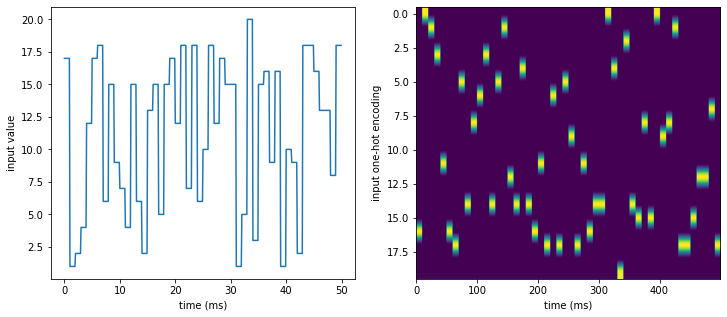

In [5]:
# Look at an example input stream.

onehot, stream = make_input(50, model)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
omit = int(model['burnIn']/model['dt']) # don't plot the burn-in period
ax[0].plot(np.arange(len(stream) - omit) * model['dt'], stream[omit:])
ax[0].set_xlabel('time (ms)')
ax[0].set_ylabel('input value')

ax[1].imshow(onehot[:, omit:], aspect='auto')
ax[1].set_xlabel('time (ms)')
ax[1].set_ylabel('input one-hot encoding')
fig.show()

C:\Users\User\AppData\Local\Temp\ipykernel_15884\3573436863.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


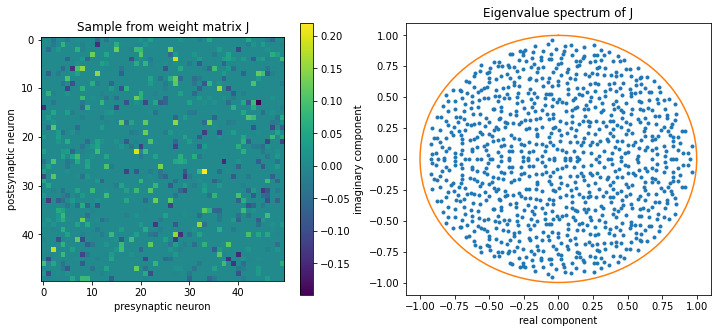

In [6]:
# Take a look at the eigenvalue spectrum of J.
w, v = np.linalg.eig(model['J'])

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
showCount = 50  # portion of J to actually show (for readability)
h = ax[0].imshow(model['J'][:showCount,:showCount])
ax[0].set_title('Sample from weight matrix J')
ax[0].set_xlabel('presynaptic neuron')
ax[0].set_ylabel('postsynaptic neuron')
plt.colorbar(h, ax=ax[0])

ax[1].plot(np.real(w),np.imag(w),'.')
ax[1].plot(np.sin(np.linspace(0,2*math.pi,100)),
           np.cos(np.linspace(0,2*math.pi,100)))  # circle with radius 1
ax[1].set_title('Eigenvalue spectrum of J')
ax[1].set_xlabel('real component')
ax[1].set_ylabel('imaginary component')
fig.show()

C:\Users\User\AppData\Local\Temp\ipykernel_15884\672881172.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


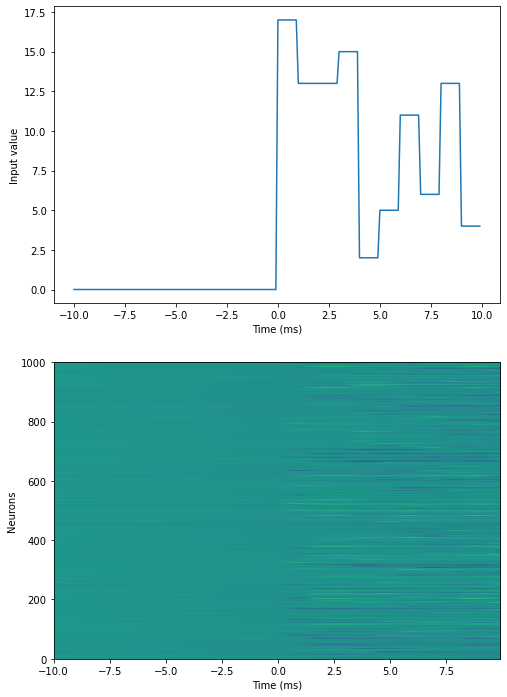

In [7]:
# Simulate the model activity.

# generate the input to the model
onehot, input_stream = make_input(10, model)

# initialize the firing rates randomly
firing_rates = np.zeros((model['N'], len(input_stream)))
firing_rates[:, 0] = np.random.uniform(0, 0.1, size=(model['N']))

for t in range(len(input_stream)-1):
  firing_rates[:,t+1] = step(firing_rates[:,t], onehot[:,t], model)


fig, ax = plt.subplots(2, 1, figsize=(8, 12))
simulation_time = np.arange(len(input_stream))*model['dt'] - model['burnIn']
ax[0].plot(simulation_time, input_stream)
ax[0].set_xlabel('Time (ms)')
ax[0].set_ylabel('Input value')

extents = [simulation_time[0],simulation_time[-1], 0, model['N']]
ax[1].imshow(firing_rates, aspect='auto', extent=extents)
ax[1].set_xlabel('Time (ms)')
ax[1].set_ylabel('Neurons')
fig.show()

Now: can you decode the model's input history from its firing rates?